# Выбор архитектуры модели для сегментации типов ландшафта по данным аэрофотосъемки

## Содержание

* [Задача](#Задача)
* [Исследуемые параметры](#Исследуемые-параметры)
* [Измеряемые характеристики](#Измеряемые-характеристики)
* [Описание исследования](#Описание-исследования)
* [Результат исследования](#Результат-исследования)
* [Вывод](#Вывод)

## Задача

Изучить влияние архитектуры сети и её параметров на качество модели и выбрать оптимальные значения.

## Исследуемые параметры

* Архитектура сети.
* Количество фильров в блоках.
* Цветность изображения.

## Измеряемые характеристики

Метрика IoU на тестовой части датасета.

## Описание исследования

Импорты библиотек и вспомогательных скриптов

In [1]:
import sys
sys.path.append('../')

from datetime import datetime
from functools import partial

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from srr.batchflow import FilesIndex, Dataset, Pipeline, F, V, B, C, R, P
from srr.batchflow.models.tf import UNet
from srr.batchflow.research import Research, Results, Option, Grid

from srr import AerialBatch
from srr.core.utils import get_origs, ce_dice_loss, make_mask

Вспомогательная функция для работы с масками:

In [2]:
# Mask classes 
# 0 Background - already included
# 1 Water
# 2 Forest land
# 3 Urban land
# 5 Rangeland
# 6 Agriculture land
# 7 Barren land

classes = (1,2)
make_mask = partial(make_mask, classes=(1,2))

Определим функцию потерь:

In [3]:
ce_dice_loss = partial(ce_dice_loss, alpha=0.75)

Задание датасета

In [4]:
ind = FilesIndex(path='../ignore/deepglobe/train/*.jpg')
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=True)

Задание модели

In [5]:
model_config = {
    'initial_block/inputs': 'images',
    'inputs': dict(images={'shape': B('image_shape')}, 
                   masks={'name':'targets',
                          'shape': (256, 256, len(classes)+1)}),
    'filters': C('filters'),
    'head/num_classes': len(classes)+1,
    'loss': ce_dice_loss,
    'optimizer': 'Adam',
    'output': ['proba']
}

Описание пайплайнов для обучения и оценки моделей

In [6]:
n_reps = 4
batch_size = 8
n_epochs = 300
n_iters = int(n_epochs * (len(ads.train) / batch_size))
iters_to_test = 500
itt = "%{}".format(iters_to_test)

print("Total number of iterations: {}.\nTest after each {} iterations.".format(n_iters, iters_to_test))

folder = '../ignore/research/global_search_3c_' + datetime.now().strftime(format='%Y%m%d%H%M')

Total number of iterations: 24075.
Test after each 500 iterations.


In [7]:
crop_shape = (256, 256)

train_template = (
      Pipeline()
      .load(ind, fmt='image', dst='images')
      .load(ind, fmt='mask', dst='masks')
      .resize(size=(1224, 1224), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origs, crop_shape, 1., src='masks', dst='origs')
      .crop(shape=crop_shape, src=[('images', 'origs'), ('masks', 'origs')], dst=['images', 'masks'])
      .rotate(P(R('randint', 0, 180)), src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .flip('lr', src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .enhance(factor=P(R('uniform', 0.5, 1.5)))
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('loss', init_on_each_run=list)
      .init_model('dynamic', C('model'), 'unet', model_config)
      .train_model('unet', images=B('images'), targets=B('masks'),
                      fetches='loss', save_to=V('loss'), mode='w')
).run(batch_size, n_epochs=n_epochs, shuffle=True, lazy=True, drop_last=True)

test_template = (
      Pipeline()    
      .load(ind, fmt='image', dst='images')
      .load(ind, fmt='mask', dst='masks')
      .resize(size=(1224, 1224), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origs, crop_shape, 1., src='masks', dst='origs')
      .crop(shape=crop_shape, src=[('images', 'origs'), ('masks', 'origs')], dst=['images', 'masks'])
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .import_model('unet', C('import_from'))
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('predictions')], mode='w')
      .gather_metrics('segmentation', axis=-1, targets=B('masks'), predictions=V('predictions'),
                      fmt='proba', save_to=V('metrics'), mode='u')
).run(batch_size, n_epochs=1, lazy=True)

Описание варьируемых параметров

In [8]:
model = Option('model', [UNet])

filter_opts = Option('filters', [
                                 [8, 16, 32, 64, 128, 256, 512],
                                 [32, 64, 128, 256, 512],
                                 [8, 16, 32, 64, 128],
                                 [64, 128, 256, 512],
                                 [32, 64, 128, 256],
                                 [16, 32, 64, 128],
                                 [128, 256, 512],
                                 [32, 64, 128],
                                 [8, 16, 32]
                                ])

opts = filter_opts * model

Вспомогательная функция

In [9]:
def get_metric(iteration, experiment, pipeline, metric='iou'):
    pipeline = experiment[pipeline].pipeline
    metrics = pipeline.get_variable('metrics')
    return metrics.evaluate(metric)

Описание эксперимента

In [10]:
train_ppl = (train_template << ads.train)
test_ppl = (test_template << ads.test)

research = (Research()
            .add_pipeline(train_ppl, name='train', variables='loss')
            .add_pipeline(test_ppl, execute=itt, name='test', run=True, import_from='train')
            .add_grid(opts)
            .add_function(get_metric, returns='metric', name='test_metric', execute=itt, dump=itt, pipeline='test')
           )

In [ ]:
research.run(n_reps=n_reps, n_iters=n_iters, workers=8, name=folder, progress_bar=True, gpu=[0,1,2,3,4,5,6,7])

Research ../ignore/research/global_search_3c_201905181413 is starting...


  0%|          | 0/866700 [00:00<?, ?it/s]

Distributor has 36 jobs with 24075 iterations. Totally: 866700


  1%|▏         | 11994/866700 [41:42<49:31:35,  4.79it/s]

## Результаты исследования

In [ ]:
# folder = '../ignore/research/UNet_segmentation_result_201903291534/'

In [12]:
df = Results(path=folder).load(use_alias=True)

In [13]:
df.head()

,config,iteration,loss,metric,name,repetition
0,"filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet",0,1.000780,NaN,train,0
1,"filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet",1,1.056820,NaN,train,0
2,"filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet",2,0.793790,NaN,train,0
3,"filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet",3,0.626260,NaN,train,0
4,"filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet",4,0.542752,NaN,train,0


In [16]:
# df[(df.name=='test_metric')]

Model configuration: 
filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet


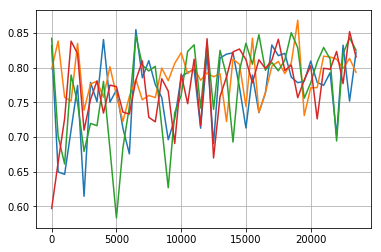

Model configuration: 
filters_[32, 64, 128, 256, 512]-model_UNet


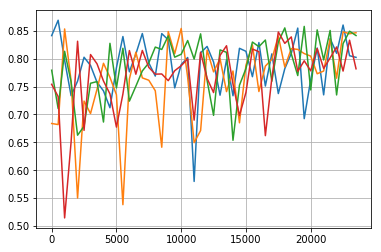

Model configuration: 
filters_[8, 16, 32, 64, 128]-model_UNet


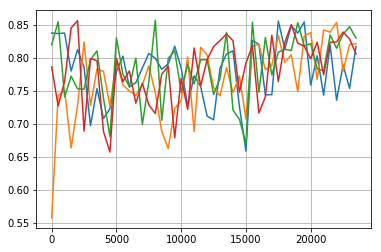

Model configuration: 
filters_[64, 128, 256, 512]-model_UNet


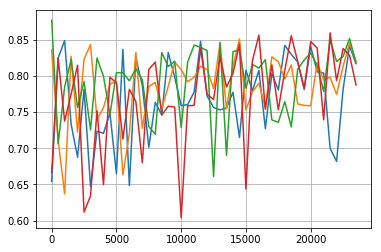

Model configuration: 
filters_[32, 64, 128, 256]-model_UNet


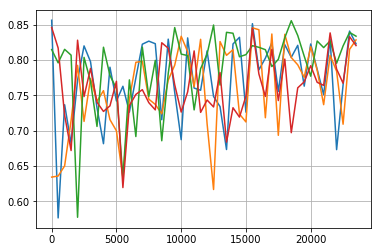

Model configuration: 
filters_[16, 32, 64, 128]-model_UNet


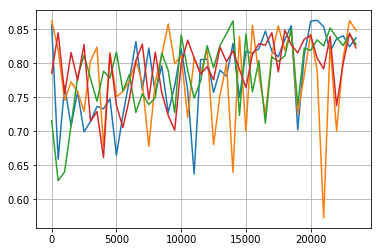

Model configuration: 
filters_[128, 256, 512]-model_UNet


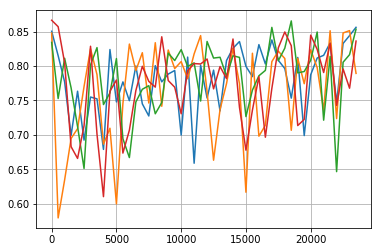

Model configuration: 
filters_[32, 64, 128]-model_UNet


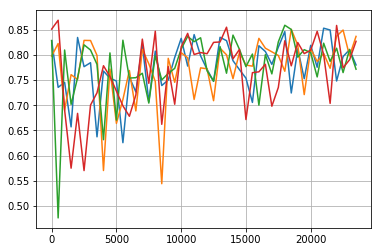

Model configuration: 
filters_[8, 16, 32]-model_UNet


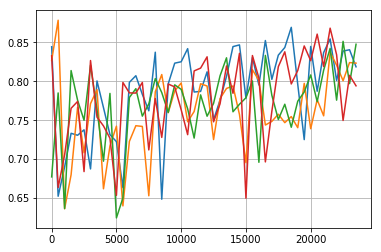

In [17]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    for rep in df.repetition.unique():
        condition = (df.name=='test_metric')&(df.config==conf)&(df.repetition==rep)
#         values = df[condition]['metrics'].apply(lambda x: x.evaluate('iou')).values
        values = df[condition]['metric']
        iters = np.arange(len(values)) * iters_to_test
        plt.plot(iters, values)
        plt.grid(True)
    plt.show()

Model configuration: 
filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet


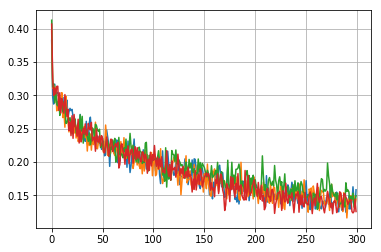

Model configuration: 
filters_[32, 64, 128, 256, 512]-model_UNet


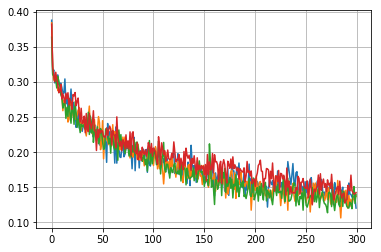

Model configuration: 
filters_[8, 16, 32, 64, 128]-model_UNet


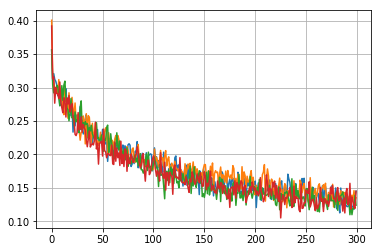

Model configuration: 
filters_[64, 128, 256, 512]-model_UNet


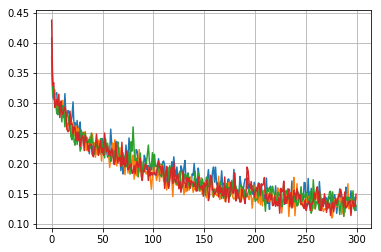

Model configuration: 
filters_[32, 64, 128, 256]-model_UNet


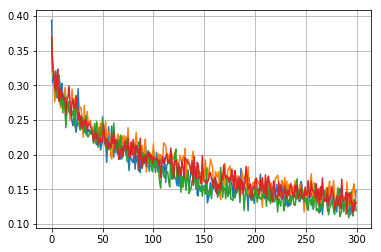

Model configuration: 
filters_[16, 32, 64, 128]-model_UNet


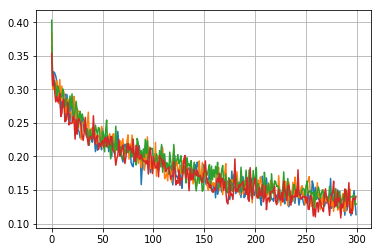

Model configuration: 
filters_[128, 256, 512]-model_UNet


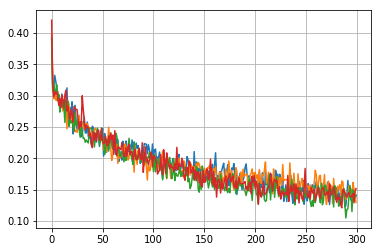

Model configuration: 
filters_[32, 64, 128]-model_UNet


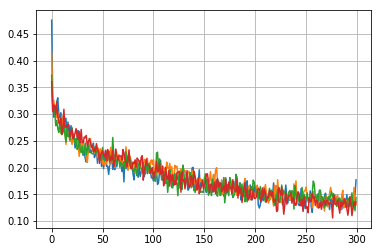

Model configuration: 
filters_[8, 16, 32]-model_UNet


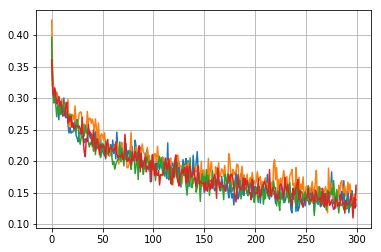

In [18]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    for rep in df.repetition.unique():
        condition = (df.name=='train')&(df.config==conf)&(df.repetition==rep)
        loss_ep = np.array(np.split(df[condition]['loss'], n_epochs))
        loss_mean = np.mean(loss_ep, axis=-1)
        plt.plot(loss_mean)
        plt.grid(True)
    plt.show()

Model configuration: 
filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet


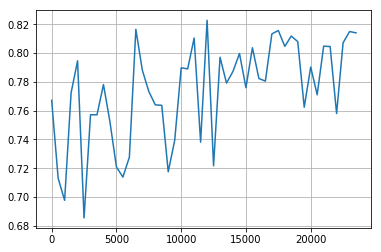

Model configuration: 
filters_[32, 64, 128, 256, 512]-model_UNet


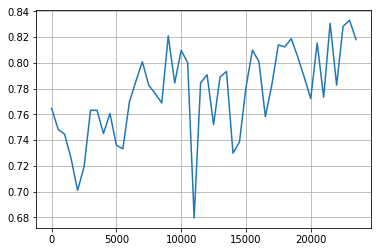

Model configuration: 
filters_[8, 16, 32, 64, 128]-model_UNet


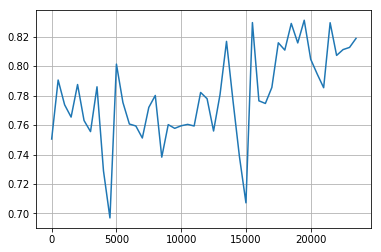

Model configuration: 
filters_[64, 128, 256, 512]-model_UNet


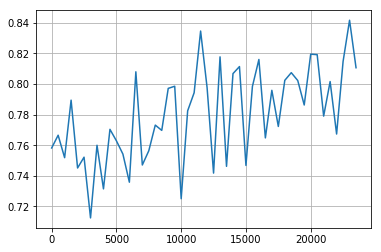

Model configuration: 
filters_[32, 64, 128, 256]-model_UNet


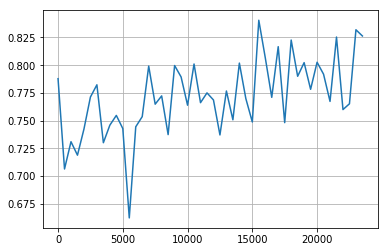

Model configuration: 
filters_[16, 32, 64, 128]-model_UNet


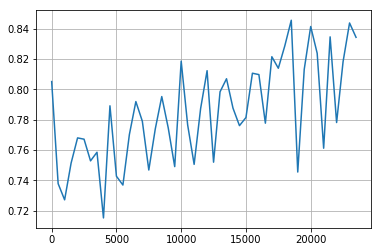

Model configuration: 
filters_[128, 256, 512]-model_UNet


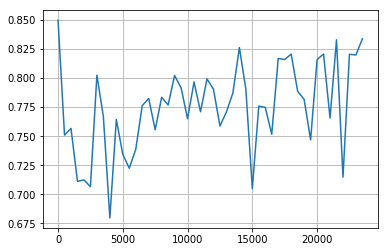

Model configuration: 
filters_[32, 64, 128]-model_UNet


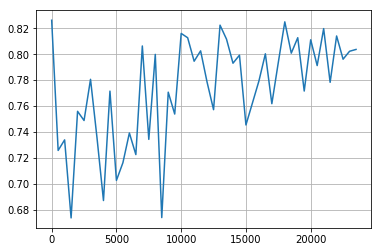

Model configuration: 
filters_[8, 16, 32]-model_UNet


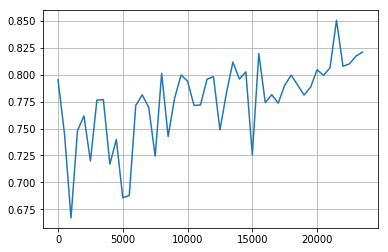

In [21]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    values = []
    for rep in df.repetition.unique():
        condition = (df.name=='test_metric')&(df.config==conf)&(df.repetition==rep)
        values.append(df[condition]['metric'])
        iters = np.arange(len(values[0])) * iters_to_test
    values = np.array(values)
    plt.plot(iters, np.mean(values, axis=0))
    plt.grid(True)
    plt.show()

Model configuration: 
filters_[8, 16, 32, 64, 128, 256, 512]-model_UNet


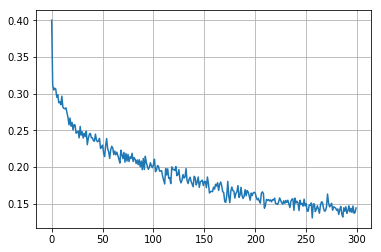

Model configuration: 
filters_[32, 64, 128, 256, 512]-model_UNet


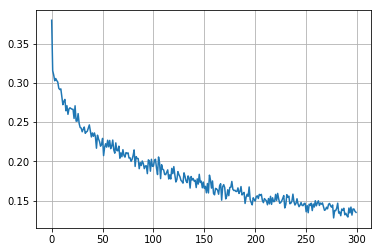

Model configuration: 
filters_[8, 16, 32, 64, 128]-model_UNet


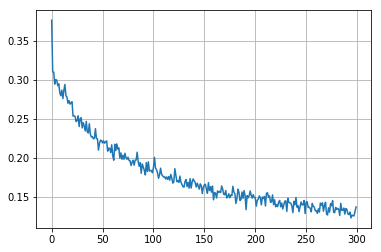

Model configuration: 
filters_[64, 128, 256, 512]-model_UNet


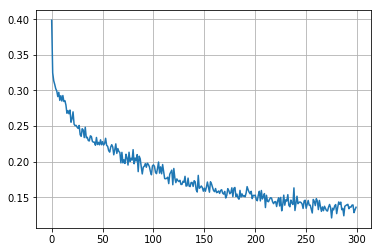

Model configuration: 
filters_[32, 64, 128, 256]-model_UNet


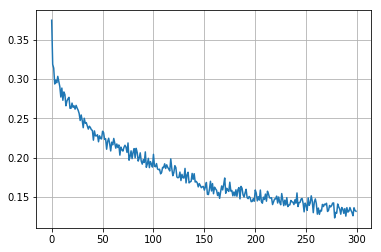

Model configuration: 
filters_[16, 32, 64, 128]-model_UNet


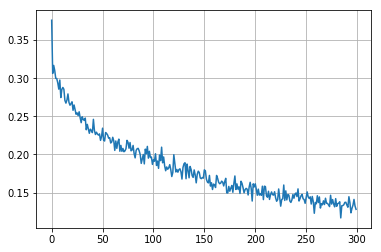

Model configuration: 
filters_[128, 256, 512]-model_UNet


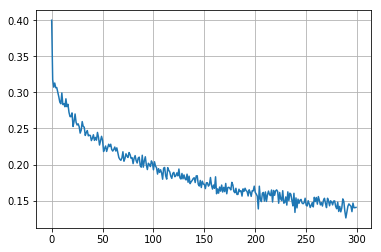

Model configuration: 
filters_[32, 64, 128]-model_UNet


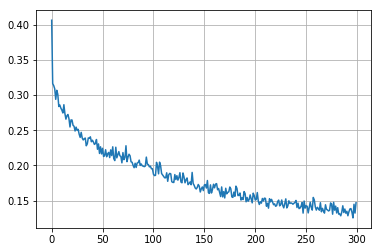

Model configuration: 
filters_[8, 16, 32]-model_UNet


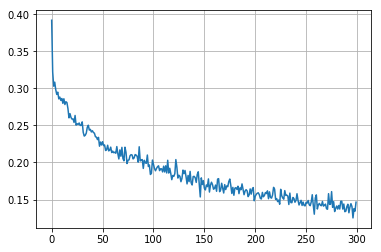

In [22]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    loss_mean = []
    for rep in df.repetition.unique():
        condition = (df.name=='train')&(df.config==conf)&(df.repetition==rep)
        loss_ep = np.array(np.split(df[condition]['loss'], n_epochs))
        loss_mean.append(np.mean(loss_ep, axis=-1))
    loss_mean = np.mean(loss_mean, 0)
    plt.plot(loss_mean)
    plt.grid(True)
    plt.show()